In [17]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv
import vtk
from vtk.util import numpy_support

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '../dataset/manifest-1674660649243'
NLST = f'{INPUT_FOLDER}/NLST'

expFolder = f'{NLST}/100004/01-02-2001-NA-NLST-LSS-01308/1.000000-2OPATOAQUL4C410.22-06725'
expFile = f'{expFolder}/1-060.dcm'

metadata = pd.read_csv(f'{INPUT_FOLDER}/metadata.csv')
patients = os.listdir(NLST)
patients.sort()

print('data loaded successfully')

data loaded successfully


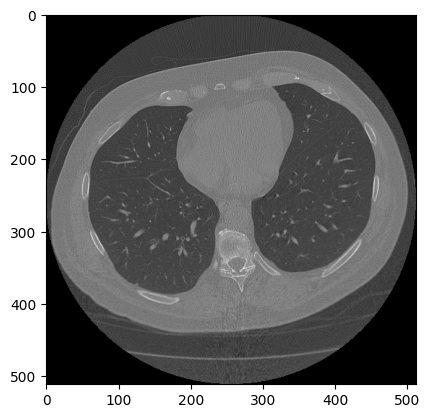

In [18]:
#dicom_obj = dicom.dcmread(f'{INPUT_FOLDER}/NLST/100029/01-02-1999-NA-NLST-LSS-60502/5.000000-0OPASESEN16B50f292212045.030.0null-16961/1-008.dcm')
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices



def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)



first_patient = load_scan(expFolder)
first_patient_pixels = get_pixels_hu(first_patient)
#plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
#plt.xlabel("Hounsfield Units (HU)")
#plt.ylabel("Frequency")
#plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[50], cmap=plt.cm.gray)
plt.show()


In [19]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (150, 512, 512)
Shape after resampling	 (300, 410, 410)


In [20]:
print(type(spacing))

<class 'numpy.ndarray'>


In [21]:
def plot_3d(image, threshold=-300, title = ''):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,x ,y = measure.marching_cubes(p, threshold)
    #print(len(measure.marching_cubes(p, threshold)))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(title)
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
#plot_3d(pix_resampled, 400)

In [22]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
        
def dilate(img, kernel_size, iteration, three_d=False, shape = 'circular'):

    img = img.copy()
    if three_d:
        if shape == 'circular' :
            kernel = morphology.ball(kernel_size).astype(np.uint8)
        elif shape == 'square' :
            kernel = np.ones((kernel_size, kernel_size, kernel_size), np.uint8)
        img = ndimage.binary_dilation(img, kernel, iterations=iteration)
    else:
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        for i, slide in enumerate(img):
            img[i] = ndimage.binary_dilation(
                slide, kernel, iterations=iteration)

    return img

    

def segment_lung_mask(image, fill_lung_structures=True, dilation = None, kernel_size = 3, iteration = 5):
    
    
    #1 in dilate does 2d dilation and 2 does 3d
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    #plot_3d(binary_image - 1, 0, 'thresholding')
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_labels = labels[0:2,0:2,0:2]
    background_label = np.median(background_labels)
        
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
        
        
    if dilation == '2d':
        binary_image = dilate(binary_image, kernel_size, iteration)
    elif dilation == '3d': 
        binary_image = dilate(binary_image, kernel_size, iteration, True)
            
    return binary_image

#segmented_lungs = segment_lung_mask(pix_resampled, False)
#segmented_lungs_fill = segment_lung_mask(pix_resampled, False)


In [23]:
#segmented_lungs_fill = segment_lung_mask(pix_resampled, False)
#segmented_lungs_fill_2d = segment_lung_mask(pix_resampled, False, dilation = '2d', kernel_size = 3, iteration = 2)
segmented_lungs_fill_3d = segment_lung_mask(pix_resampled, True, dilation = '3d', kernel_size = 2, iteration = 2)

#plot_3d(segmented_lungs_fill_3d, 0, '3d dilation')
#plot_3d(segmented_lungs_fill, 0, 'without dilation')
#plot_3d(segmented_lungs_fill_2d, 0, '2d dilation')


AttributeError: 'int' object has no attribute 'copy'

In [ ]:
#change the opacity and give it some color 
colors = vtk.vtkNamedColors()

def numpyToImageDate(numpyScan):
    scan = numpyScan.transpose(2,0,1)
    imData = vtk.vtkImageData()
    vtk_data = numpy_support.numpy_to_vtk(scan.ravel(order= 'F'), deep=True, array_type=vtk.VTK_DOUBLE)

    imData.SetDimensions(scan.shape)
    imData.SetSpacing([.1,.1,.1])
    imData.SetOrigin([0,0,0])
    imData.GetPointData().SetScalars(vtk_data)

    return imData


def imDataToVolumeMapper(imData):
    
 
    opacity = vtk.vtkPiecewiseFunction()
    opacity.AddPoint(0, 0)
    opacity.AddPoint(1, .1)
 

    color = vtk.vtkColorTransferFunction()
    r, g, b = colors.GetColor3ub('black')
    color.AddRGBPoint(0, r, g, b)
    r, g, b = colors.GetColor3ub('white')
    color.AddRGBPoint(1, r, g, b)

    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(color)
    volumeProperty.SetScalarOpacity(opacity)
    volumeProperty.SetInterpolationTypeToLinear()
    volumeProperty.SetIndependentComponents(2)


    volumeMapper = vtk.vtkOpenGLGPUVolumeRayCastMapper()
    volumeMapper.SetInputData(imData)
    #volumeMapper.SetBlendModeToAverageIntensity()
    return volumeMapper, volumeProperty 


def vMapperToVolume(volume, mapper, property):
    volume.SetMapper(mapper)
    volume.SetProperty(property)
    return volume


def renderVol(volume):

    ren = vtk.vtkRenderer()
    ren.AddVolume(volume)
    ren.SetBackground(colors.GetColor3ub('black'))
    return ren

def visualize(ren):

    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(ren)
    render_window.SetSize(400, 400)


    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)
    render_window_interactor.Initialize()

    ren.ResetCamera()
    ren.GetActiveCamera().Zoom(1.5)

    render_window.Render()
    render_window_interactor.Start()


imData = numpyToImageDate(segmented_lungs_fill_3d)
volumeMapper, volumeProperty = imDataToVolumeMapper(imData)
vtkVolume = vtk.vtkVolume()
volume = vMapperToVolume(vtkVolume, volumeMapper, volumeProperty)
ren = renderVol(volume)
visualize(ren)



'''
mapper = vtk.vtkDataSetMapper()
mapper.SetInputData(imdata)
actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(1,1,1)
actor.RotateX(30.0)
actor.RotateY(-45)


renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1.0, 1.0, 1.0)


render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window.SetSize(400, 400)

render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)
render_window_interactor.Initialize()
renderer.ResetCamera()
renderer.GetActiveCamera().Zoom(1.5)
render_window.Render()
render_window_interactor.Start()



'''

'''

# Create a 3D NumPy array
array = np.zeros((10, 10, 10))

# Convert the NumPy array to a VTK structured grid
grid = vtk.vtkStructuredGrid()
grid.SetDimensions(array.shape)

grid.SetPoints(vtk.vtkPoints().DeepCopy(vtk_data))

# Create a VTK data array for the grid scalar values
scalars = vtk.vtkFloatArray()
scalars.SetNumberOfTuples(array.size)
scalars.SetVoidArray(array, array.nbytes, 1)
scalars.SetName("Scalars")
grid.GetPointData().SetScalars(scalars)

# Visualize the grid using VTK
mapper = vtk.vtkDataSetMapper()
mapper.SetInputData(grid)
actor = vtk.vtkActor()
actor.SetMapper(mapper)

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)

render_window.Render()
render_window_interactor.Start()

'''

'\n\n# Create a 3D NumPy array\narray = np.zeros((10, 10, 10))\n\n# Convert the NumPy array to a VTK structured grid\ngrid = vtk.vtkStructuredGrid()\ngrid.SetDimensions(array.shape)\n\ngrid.SetPoints(vtk.vtkPoints().DeepCopy(vtk_data))\n\n# Create a VTK data array for the grid scalar values\nscalars = vtk.vtkFloatArray()\nscalars.SetNumberOfTuples(array.size)\nscalars.SetVoidArray(array, array.nbytes, 1)\nscalars.SetName("Scalars")\ngrid.GetPointData().SetScalars(scalars)\n\n# Visualize the grid using VTK\nmapper = vtk.vtkDataSetMapper()\nmapper.SetInputData(grid)\nactor = vtk.vtkActor()\nactor.SetMapper(mapper)\n\nrenderer = vtk.vtkRenderer()\nrenderer.AddActor(actor)\n\nrender_window = vtk.vtkRenderWindow()\nrender_window.AddRenderer(renderer)\n\nrender_window_interactor = vtk.vtkRenderWindowInteractor()\nrender_window_interactor.SetRenderWindow(render_window)\n\nrender_window.Render()\nrender_window_interactor.Start()\n\n'